In [1803]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1805]:
# Load the dataset
df = pd.read_csv('day.csv')

In [1807]:
# Display the first few rows of the dataframe for understanding
print(df.head())

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  


In [1809]:
# Check for any missing values
print(df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [1811]:
# Basic stats understanding using description & data types
print(df.describe())

df.dtypes

          instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.5448

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

# Pre-Processing

In [1814]:
# Convert 'dteday' to datetime and extract day of the month
df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')
df['day_of_month'] = df['dteday'].dt.day

# Drop the original 'dteday' column as it's no longer needed. 
# As per problem statement, cnt is the sum of registered and casual, so lets drop these as well.
# Drop instant as its the serial number for the data

df.drop(['dteday', 'registered', 'casual', 'instant'], axis=1, inplace=True)


In [1816]:
# Encode Categorical Variables

In [1818]:
def convert_columns_to_int(df, data_types):
    for column in df.columns:
        if df[column].dtype in data_types:
            df[column] = df[column].astype('int')
    return df

In [1820]:
# Handle categorical variables using Encoder or get_dummies
# Converting 'season' and 'weathersit' from numerical labels to categorical
# df['season'] = df['season'].astype('category')
# df['weathersit'] = df['weathersit'].astype('category')

# Define the mappings for season and weathersit as per the dataset description

season_map = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weathersit_map = {
    1: 'Clear_Few_clouds_Partly_cloudy',
    2: 'Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds',
    3: 'Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds',
    4: 'Heavy_Rain_Ice_Pallets_Thunderstorm_Mist_Snow_Fog'
}

# Apply these mappings to the dataframe
df['season'] = df['season'].map(season_map)
df['weathersit'] = df['weathersit'].map(weathersit_map)

# df = pd.get_dummies(df, columns=['season', 'weathersit'], drop_first=True)
df = pd.get_dummies(df, drop_first=True)
df = convert_columns_to_int(df, data_types=[bool])

In [1822]:
df.dtypes

yr                                                                                              int64
mnth                                                                                            int64
holiday                                                                                         int64
weekday                                                                                         int64
workingday                                                                                      int64
temp                                                                                          float64
atemp                                                                                         float64
hum                                                                                           float64
windspeed                                                                                     float64
cnt                                                                               

# Exploratory Data Analysis

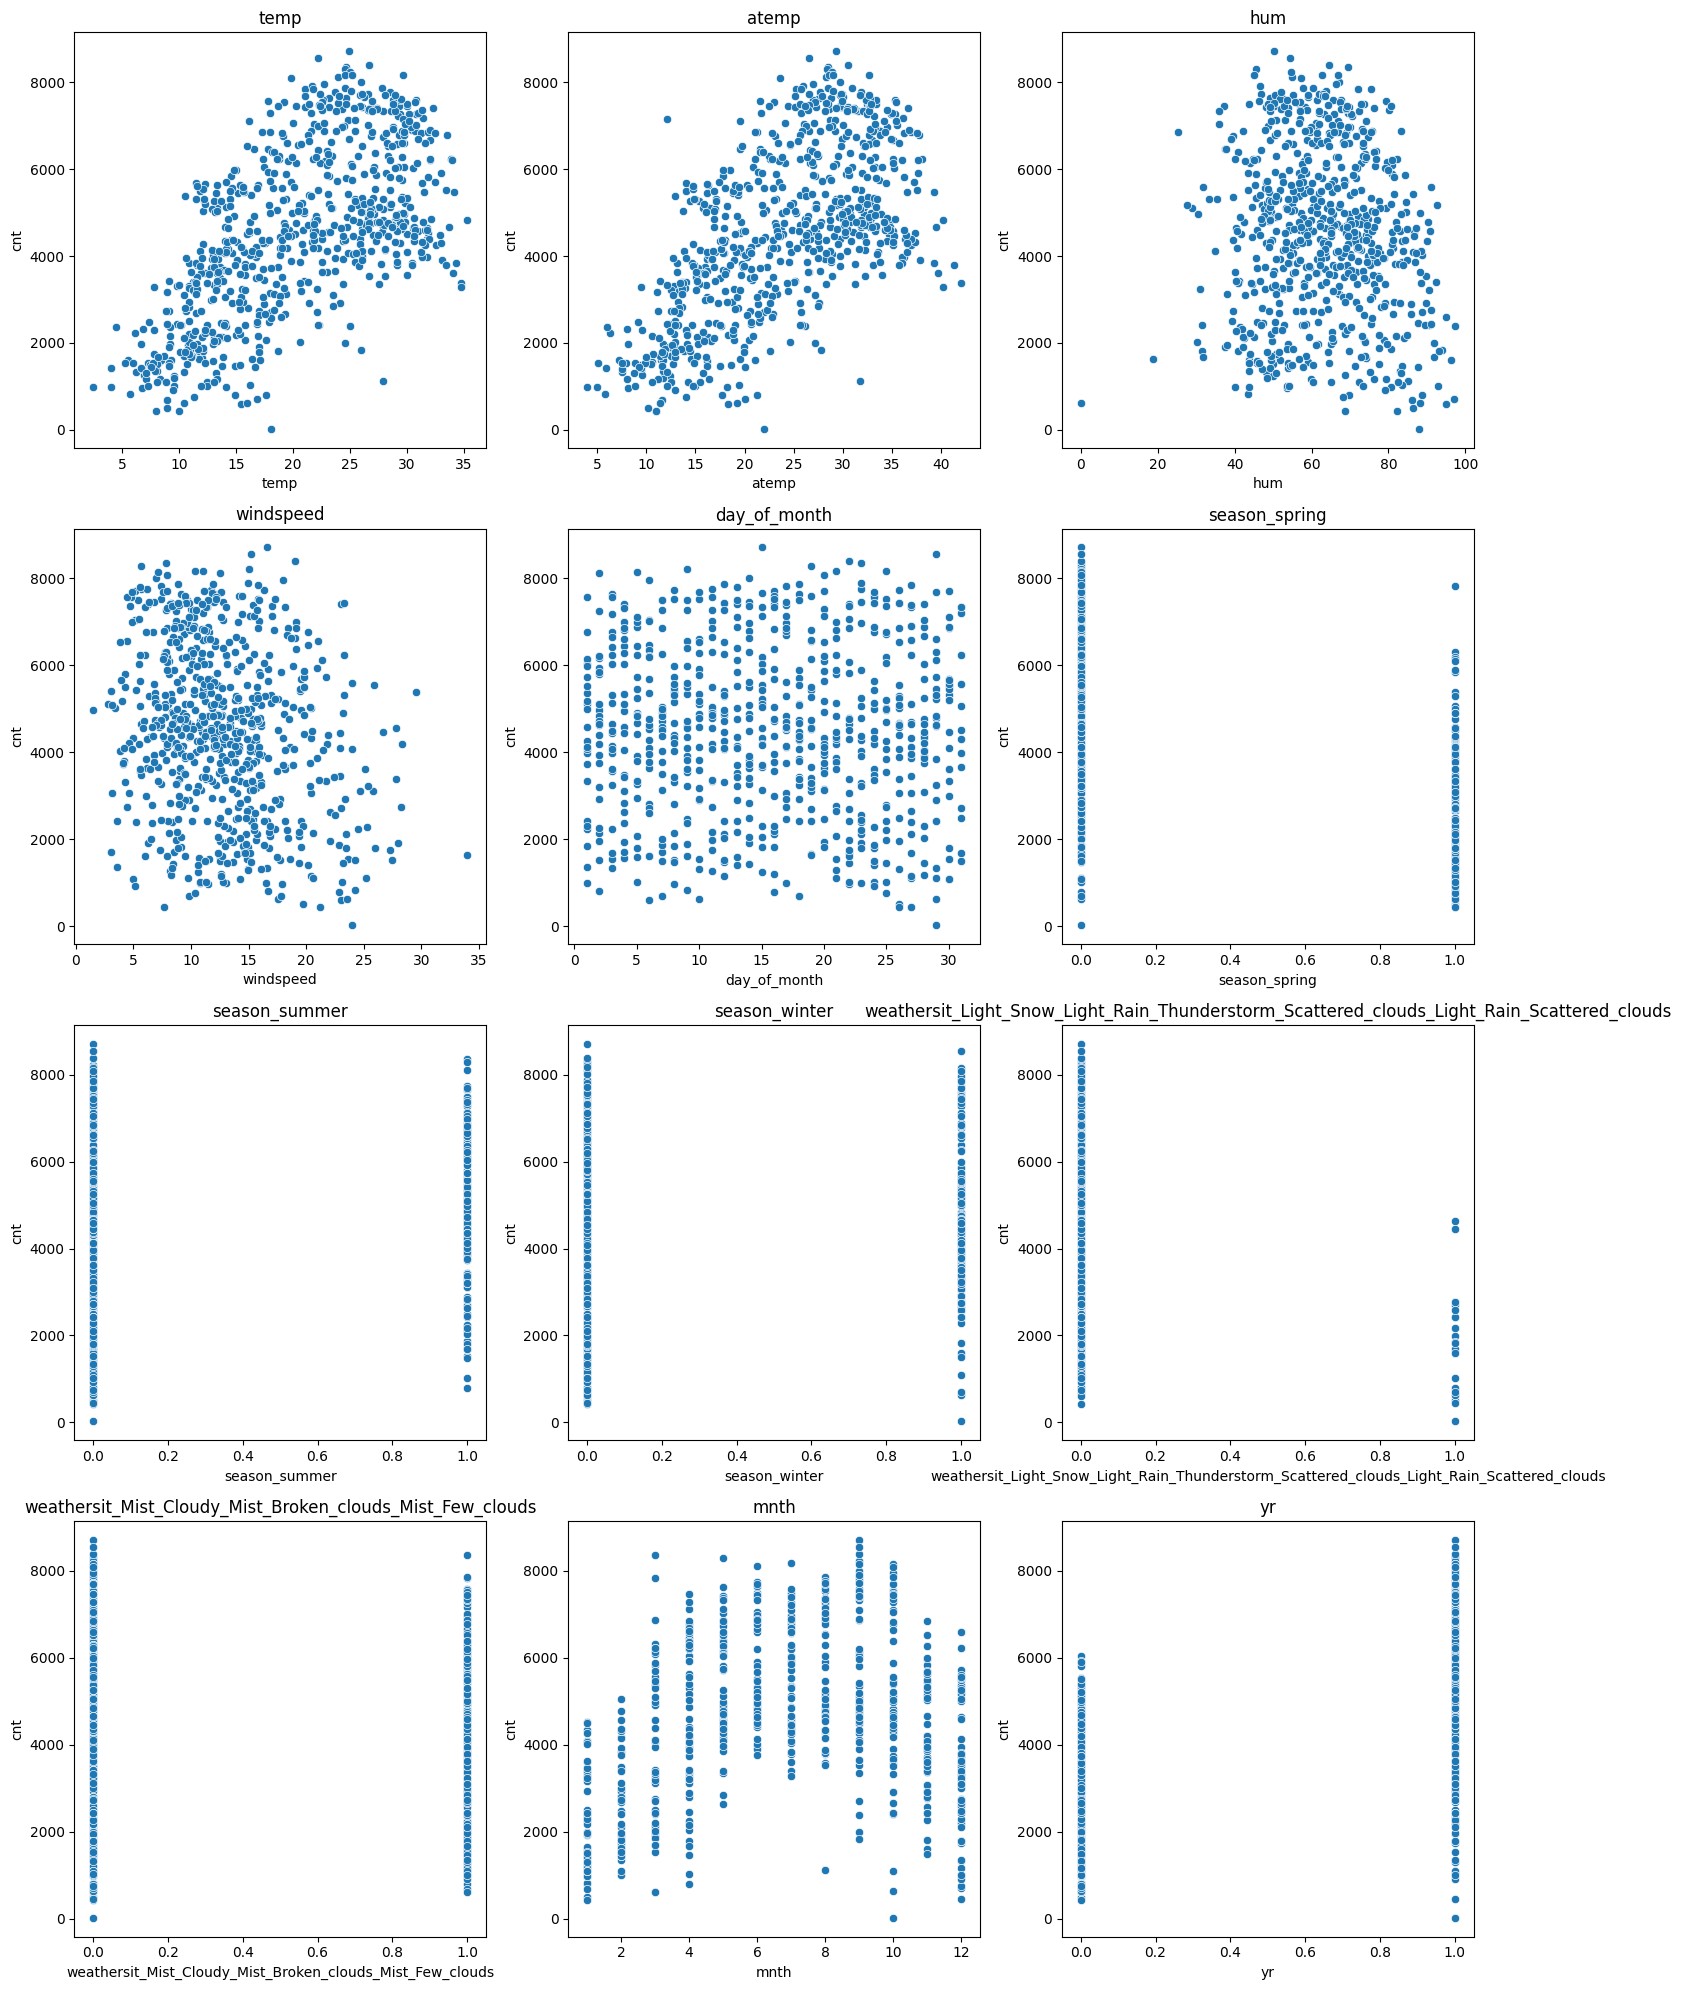

In [1825]:
# Visualizing the relationship between features and the cnt (target) variable
features = ['temp', 'atemp', 'hum', 'windspeed', 'day_of_month', 'season_spring', 'season_summer', 
            'season_winter', 'weathersit_Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds',
            'weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds','mnth','yr']

plt.figure(figsize=(15, 20))  # Width, Height in inches

n_cols = 3
n_rows = len(features) // n_cols + (len(features) % n_cols > 0)

for index, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, index + 1)  # Subplot for each feature
    sns.scatterplot(x=df[feature], y=df['cnt'])  # Create scatter plot
    plt.title(feature)  # Set title to the name of the feature

plt.tight_layout()
plt.show()  # Display the plot

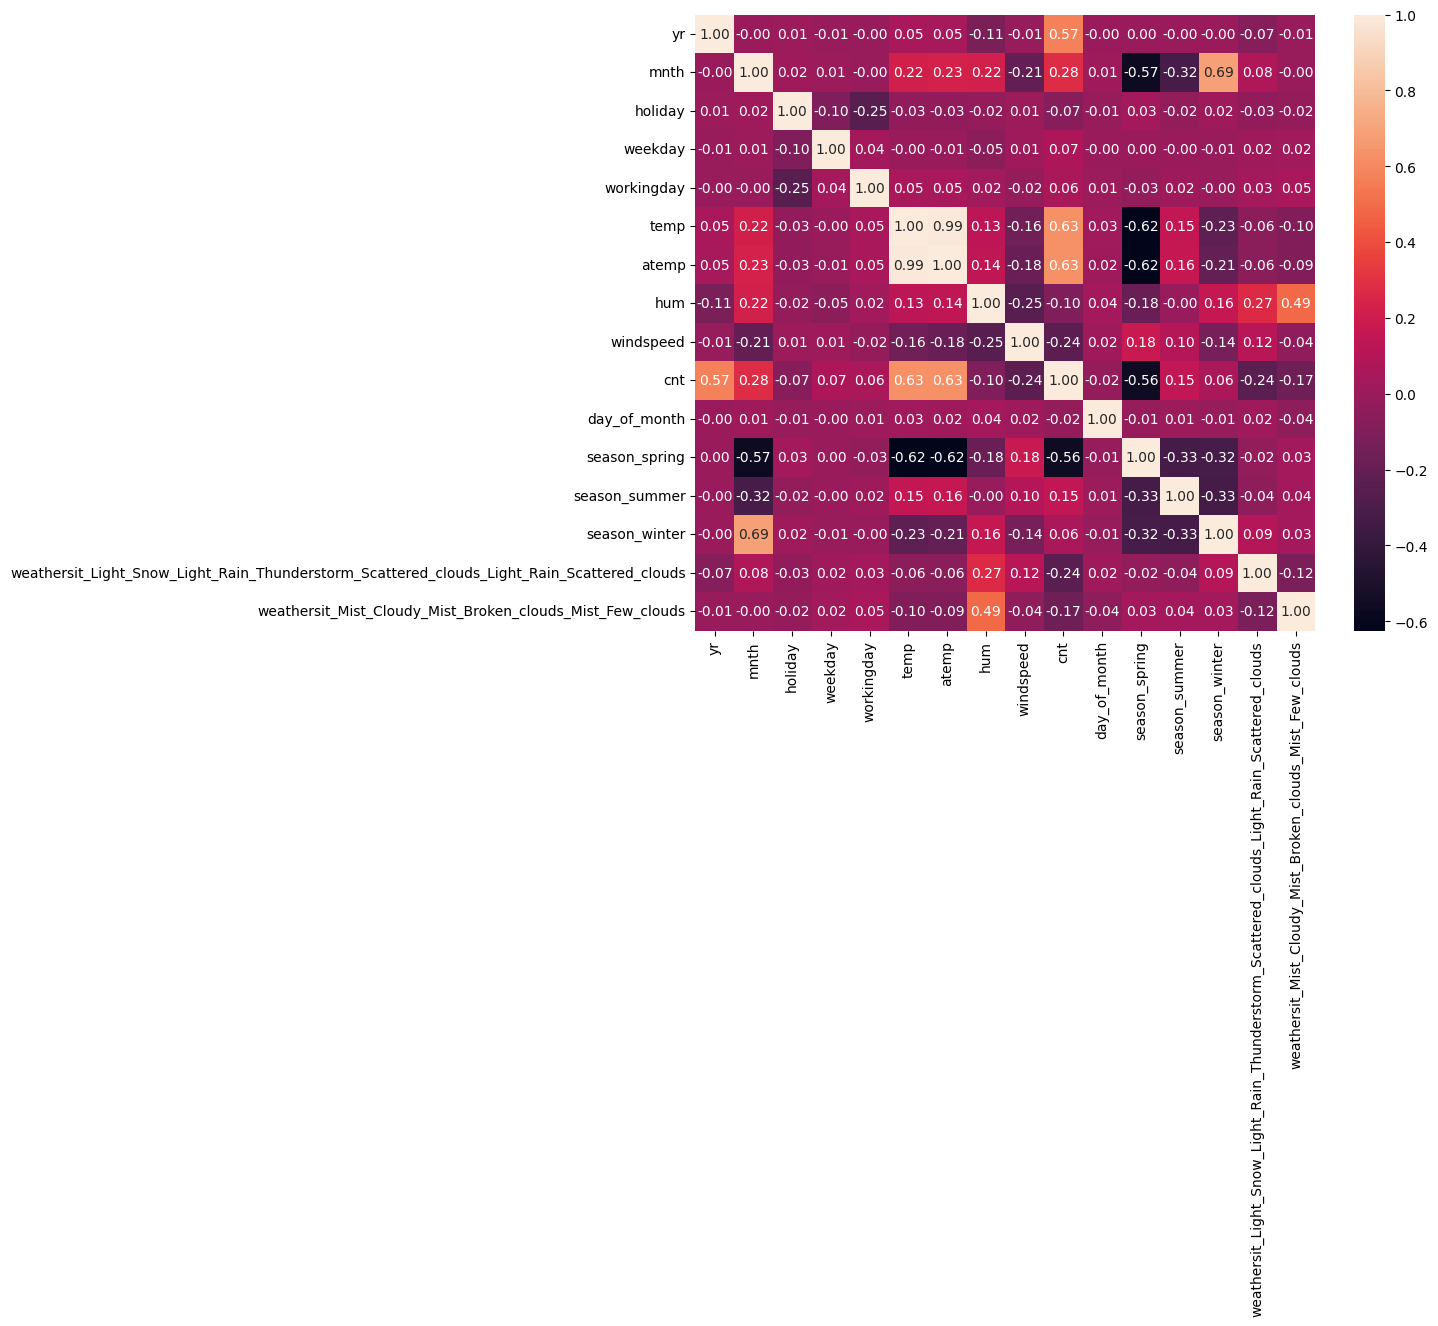

In [1827]:
# Correlation matrix to identify the variable with the highest correlation to 'cnt'

plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [1829]:
# Prepare data for Linear Regression Model with y as cnt and rest of columns as X

y = df.pop('cnt')
X = df


In [1831]:
print("Share of X: ",X.shape)
print("Share of y: ",y.shape)
X.head()

Share of X:  (730, 15)
Share of y:  (730,)


,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,day_of_month,season_spring,season_summer,season_winter,weathersit_Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds,weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,1,1,0,0,0,1
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,2,1,0,0,0,1
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,3,1,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,4,1,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,5,1,0,0,0,0


In [1833]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [1835]:
# Scale the columns in training and testing set

scale = MinMaxScaler()
scale_columns = ['temp','atemp','mnth','hum','weekday','windspeed','day_of_month']
X_train[scale_columns] = scale.fit_transform(X_train[scale_columns])
X_test[scale_columns] = scale.transform(X_test[scale_columns])

In [1837]:
X_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,day_of_month,season_spring,season_summer,season_winter,weathersit_Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds,weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds
367,1,0.000000,0,0.333333,1,0.113228,0.061963,0.454701,0.695175,0.066667,1,0,0,0,0
648,1,0.818182,0,0.666667,1,0.468352,0.462175,0.477458,0.299450,0.333333,0,0,1,0,0
44,0,0.090909,0,0.166667,1,0.443431,0.419099,0.387290,0.807474,0.433333,1,0,0,0,0
705,1,1.000000,0,0.833333,1,0.326094,0.318824,0.787463,0.189819,0.200000,0,0,1,0,1
379,1,0.000000,0,0.000000,0,0.133996,0.108365,0.431945,0.449210,0.466667,1,0,0,0,0


In [1839]:
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

                                              feature         VIF
0                                                  yr    2.097361
1                                                mnth   11.165945
2                                             holiday    1.112255
3                                             weekday    3.077280
4                                          workingday    3.151629
5                                                temp  417.405675
6                                               atemp  407.673065
7                                                 hum   31.034563
8                                           windspeed    5.003258
9                                        day_of_month    3.606930
10                                      season_spring    4.524693
11                                      season_summer    2.646671
12                                      season_winter    4.325554
13  weathersit_Light_Snow_Light_Rain_Thunderstorm_...    1.242124
14  weathe

In [1841]:
# Build the model to understand the statistics and then decide to drop the features with VIF > 5

lm_obj = LinearRegression()

X_train_const = sm.add_constant(X_train)
lr_model_1 = sm.OLS(y_train,X_train_const).fit()

print(lr_model_1.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     199.3
Date:                Wed, 01 Jan 2025   Prob (F-statistic):          9.07e-215
Time:                        22:00:18   Log-Likelihood:                -4719.2
No. Observations:                 584   AIC:                             9470.
Df Residuals:                     568   BIC:                             9540.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [1843]:
# Drop feature with high P ratio and high VIF. 
# As we see atemp has high P ratio and also VIF, lets drop atemp and re build the model

X_train_2 = X_train.drop(['atemp'], axis = 1)

In [1845]:
X_train_2.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,day_of_month,season_spring,season_summer,season_winter,weathersit_Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds,weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds
367,1,0.000000,0,0.333333,1,0.113228,0.454701,0.695175,0.066667,1,0,0,0,0
648,1,0.818182,0,0.666667,1,0.468352,0.477458,0.299450,0.333333,0,0,1,0,0
44,0,0.090909,0,0.166667,1,0.443431,0.387290,0.807474,0.433333,1,0,0,0,0
705,1,1.000000,0,0.833333,1,0.326094,0.787463,0.189819,0.200000,0,0,1,0,1
379,1,0.000000,0,0.000000,0,0.133996,0.431945,0.449210,0.466667,1,0,0,0,0


In [1847]:
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_2.values, i) for i in range(len(X_train_2.columns))]
print(vif_data)

                                              feature        VIF
0                                                  yr   2.095704
1                                                mnth  11.165892
2                                             holiday   1.110148
3                                             weekday   3.069700
4                                          workingday   3.151627
5                                                temp  16.386229
6                                                 hum  30.902771
7                                           windspeed   4.785776
8                                        day_of_month   3.598664
9                                       season_spring   4.446588
10                                      season_summer   2.548296
11                                      season_winter   4.184933
12  weathersit_Light_Snow_Light_Rain_Thunderstorm_...   1.234418
13  weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist...   2.357536


In [1849]:
# As we can see mnth, temp, hum still has VIF > 5, this time, we shall perform RFE to select the features
# Select the columns for training using RFE

rfe = RFE(estimator=lm_obj, n_features_to_select=12)

rfe.fit(X_train_2,y_train)

list(zip(X_train_2.columns, rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 3),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day_of_month', False, 2),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('weathersit_Light_Snow_Light_Rain_Thunderstorm_Scattered_clouds_Light_Rain_Scattered_clouds',
  True,
  1),
 ('weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist_Few_clouds', True, 1)]

In [1851]:
X_train_3 = X_train_2.loc[:, rfe.support_]

In [1853]:
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_3.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_3.values, i) for i in range(len(X_train_3.columns))]
print(vif_data)

                                              feature        VIF
0                                                  yr   2.092972
1                                             holiday   1.102887
2                                             weekday   3.029529
3                                          workingday   3.144235
4                                                temp  15.512118
5                                                 hum  27.278705
6                                           windspeed   4.675231
7                                       season_spring   3.971196
8                                       season_summer   2.238353
9                                       season_winter   3.039449
10  weathersit_Light_Snow_Light_Rain_Thunderstorm_...   1.226954
11  weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist...   2.279363


In [1855]:
X_train_3 = X_train_3.drop(['hum'], axis = 1)

In [1857]:
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_3.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_3.values, i) for i in range(len(X_train_3.columns))]
print(vif_data)

                                              feature       VIF
0                                                  yr  2.079664
1                                             holiday  1.100969
2                                             weekday  3.020410
3                                          workingday  3.116212
4                                                temp  5.164021
5                                           windspeed  4.636663
6                                       season_spring  2.291092
7                                       season_summer  1.861294
8                                       season_winter  1.757901
9   weathersit_Light_Snow_Light_Rain_Thunderstorm_...  1.072994
10  weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist...  1.543989


In [1859]:
X_train_3 = X_train_3.drop(['temp'], axis = 1)

In [1861]:
# Check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_3.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_3.values, i) for i in range(len(X_train_3.columns))]
print(vif_data)

                                             feature       VIF
0                                                 yr  1.899331
1                                            holiday  1.079930
2                                            weekday  2.589656
3                                         workingday  2.657021
4                                          windspeed  3.922064
5                                      season_spring  1.935157
6                                      season_summer  1.861273
7                                      season_winter  1.723555
8  weathersit_Light_Snow_Light_Rain_Thunderstorm_...  1.072277
9  weathersit_Mist_Cloudy_Mist_Broken_clouds_Mist...  1.527717


In [1863]:
X_train_3_const = sm.add_constant(X_train_3)
lr_model_2 = sm.OLS(y_train,X_train_3_const).fit()

print(lr_model_2.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     185.6
Date:                Wed, 01 Jan 2025   Prob (F-statistic):          1.86e-172
Time:                        22:00:53   Log-Likelihood:                -4833.1
No. Observations:                 584   AIC:                             9688.
Df Residuals:                     573   BIC:                             9736.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [1865]:
# Test with y_test and X_test data set to check if accuracy is close to training


X_test_3 = X_test[X_train_3.columns]
X_test_3_const = sm.add_constant(X_test_3)

y_test_pred = lr_model_2.predict(X_test_3_const)

# R-squared
r_squared = r2_score(y_test, y_test_pred)

print(f"R-squared: {r_squared:.2f}")


R-squared: 0.73


In [1867]:
# As we see R-squared of testing is closely aligned with R-squared of training hence the model trained is consider good and further analysis is carried to verify the hypothesis assumptions.

/var/folders/pd/mflxpxns0m19tcw2lzd7tstc0000gn/T/ipykernel_31631/3072776741.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_test_pred ,bins =30)


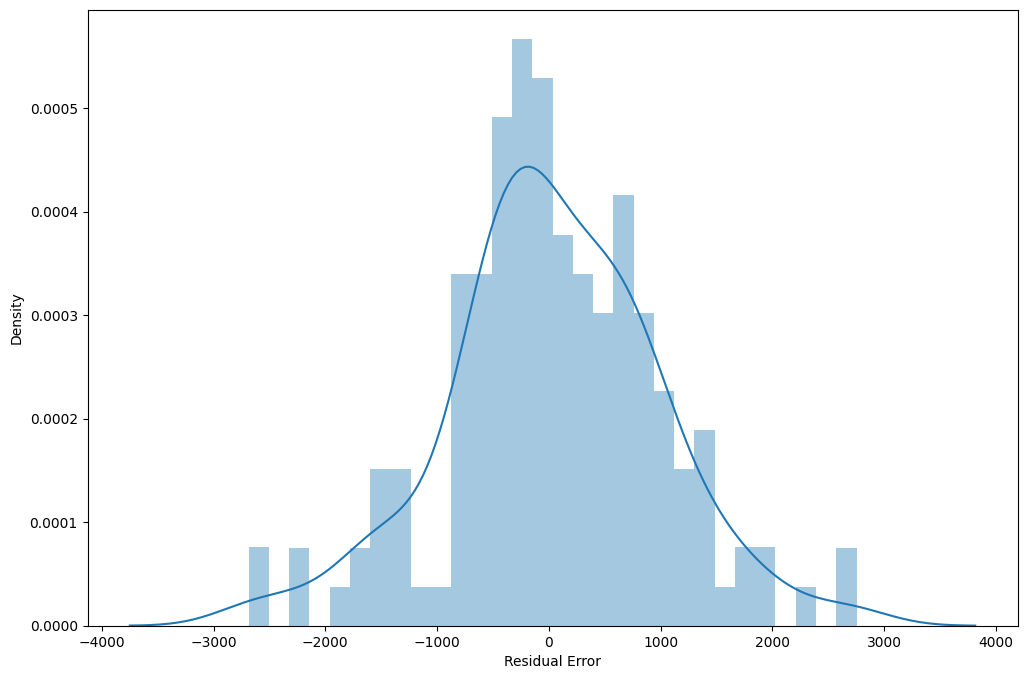

In [1869]:
# plotting the error distribution

plt.figure(figsize=(12,8))
sns.distplot(y_test - y_test_pred ,bins =30)
plt.xlabel("Residual Error")
plt.show()


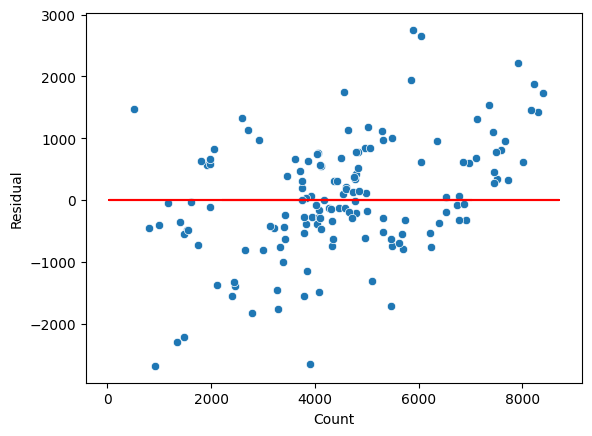

In [1871]:
# Residual Plot
sns.scatterplot(x=y_test,y=y_test - y_test_pred)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

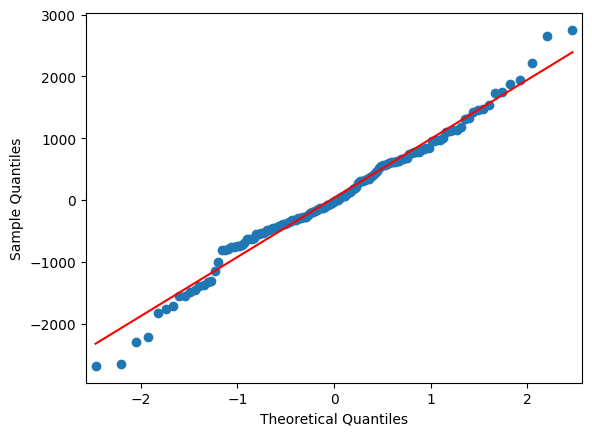

In [1873]:
# QQ Plot to check for normality of residuals
qqplot(y_test - y_test_pred, line='s')
plt.show()

In [1875]:
# Display model coefficients to identify the top 3 features
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("Top 3 features contributing to the model:")
print(coefficients.sort_values(by='Coefficient', ascending=False).head(3))

Top 3 features contributing to the model:
          Feature  Coefficient
5            temp  3899.933783
0              yr  1977.897917
12  season_winter   850.269435
